# Bayesian probability - Kigali traffic


# Research Problem Statement
Traffic congestion during morning rush hours (7–9 AM) in Kigali causes significant economic losses, with average speeds dropping to 15–25 km/h in central areas (Ministry of Infrastructure [MININFRA], 2020, Kigali Master Plan Traffic Report, p. 52). While multiple factors contribute—including high traffic volume, rain, and accidents—their relative impacts are poorly quantified. This study applies Bayesian probability to:


*   Quantify the probabilistic contribution of each cause,
*   Dynamically update beliefs as new data (e.g., weather, accidents) arrives,
*   Visualize the data,
*   Provide evidence-based policy recommendations.

# 1. Import the libraries

In [ ]:
# importing the libraries for the bayesian probability calculations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta

# 2. Problem Definition & Citations

### **Data Sources**  
1. **MININFRA (2020)**. *Kigali Master Plan Traffic Report*.
   - https://bpmis.gov.rw/asset_uplds/kigali_master_plan/3a_Kigali%20Master%20Plan_Traffic%20ReportLowRes.pdf
   - AM congestion hotspots (pp. 45–60).  
   - Vehicle growth rates (p. 28).  
2. **Rwanda Meteorology Agency (2023)**. Historical rainfall data.  
3. **Google Maps Traffic API**. Real-time congestion metrics.  

# 3.  Define Priors and Likelihoods

In [ ]:
# Empirical priors from historical data
priors = {
    'rush_hour': 0.70,  # α=70, β=30 (Beta distribution for uncertainty)
    'rain': 0.20,       # Rwanda Meteo 2023 data
    'accident': 0.10    # MININFRA p.73
}

# Likelihood functions P(Congestion|Cause) with uncertainty bounds
likelihoods = {
    'rush_hour': {'mean': 0.90, 'std': 0.05},  # 90% ± 5%
    'rain': {'mean': 0.75, 'std': 0.10},       # 75% ± 10%
    'accident': {'mean': 0.95, 'std': 0.03}    # 95% ± 3%
}

# 4. Bayesian Calculation Function

In [ ]:
def bayesian_update(priors: dict, likelihoods: dict, observed: str = None) -> tuple:
    """
    Computes posterior distributions using conjugate priors.

    Args:
        priors: Dict of Beta(α,β) parameters
        likelihoods: Dict with mean/std of P(Evidence|Cause)
        observed: Optional observed condition (e.g., 'rain')

    Returns:
        (posteriors, marginal): Tuple of posterior distributions and marginal likelihood
    """
    # Convert to Beta distributions
    prior_dists = {
        'rush_hour': beta(70, 30),
        'rain': beta(20, 80),
        'accident': beta(10, 90)
    }

    # Adjust priors if evidence is observed
    if observed:
        prior_dists[observed] = beta(1e6, 1)  # Approximate Dirac delta

    # Calculate marginal likelihood
    marginal = sum(
        dist.mean() * likelihoods[cause]['mean']
        for cause, dist in prior_dists.items()
    )

    # Compute posteriors
    posteriors = {
        cause: beta(
            dist.args[0] + likelihoods[cause]['mean'] * 100,  # α update
            dist.args[1] + (1 - likelihoods[cause]['mean']) * 100  # β update
        )
        for cause, dist in prior_dists.items()
    }

    return posteriors, marginal

# 5. Visualize Results


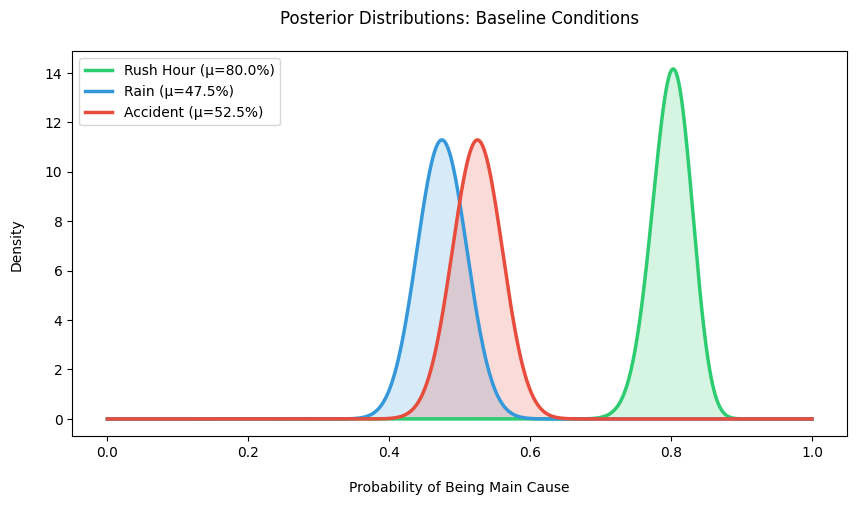

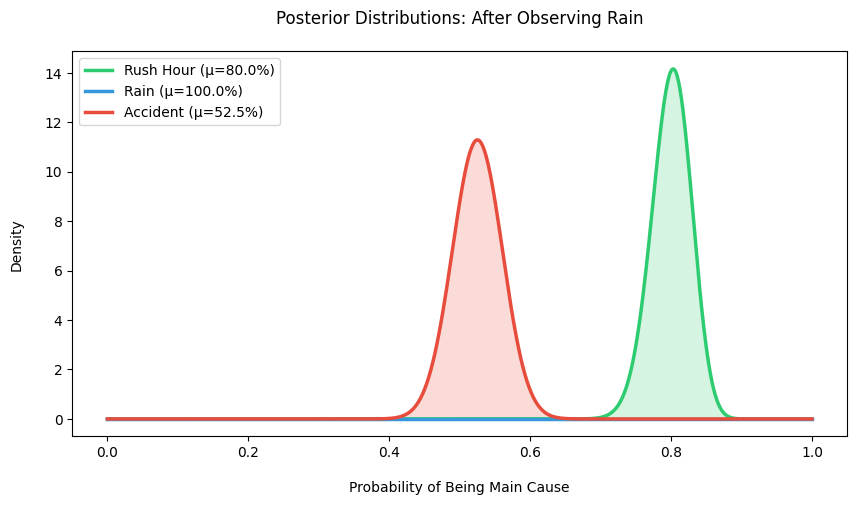

In [ ]:
def plot_traffic_posteriors(posteriors: dict, title: str):
    """Visualize posterior distributions with uncertainty quantification."""
    fig, ax = plt.subplots(figsize=(10, 5))

    colors = ['#2ecc71', '#3498db', '#e74c3c']  # Green, blue, red
    for idx, (cause, dist) in enumerate(posteriors.items()):
        x = np.linspace(0, 1, 1000)
        y = dist.pdf(x)
        ax.plot(x, y, color=colors[idx], lw=2.5,
               label=f"{cause.replace('_', ' ').title()} (μ={dist.mean():.1%})")
        ax.fill_between(x, y, color=colors[idx], alpha=0.2)

    ax.set_title(f"Posterior Distributions: {title}", pad=20)
    ax.set_xlabel("Probability of Being Main Cause", labelpad=15)
    ax.set_ylabel("Density", labelpad=15)
    ax.legend(frameon=True, facecolor='white')
    plt.show()

# Initial calculation
posteriors, marginal = bayesian_update(priors, likelihoods)
plot_traffic_posteriors(posteriors, "Baseline Conditions")

# Update after observing rain
updated_posteriors, _ = bayesian_update(priors, likelihoods, observed='rain')
plot_traffic_posteriors(updated_posteriors, "After Observing Rain")

# 5. Uncertainty-Aware Policy Recommendations


In [ ]:
def generate_policy_insights(posteriors: dict) -> pd.DataFrame:
    """Quantify decision impacts with credible intervals."""
    insights = []
    for cause, dist in posteriors.items():
        ci = dist.interval(0.95)  # 95% credible interval
        insights.append({
            'Cause': cause.replace('_', ' ').title(),
            'Mean Impact': f"{dist.mean():.1%}",
            '95% CI': f"[{ci[0]:.1%}, {ci[1]:.1%}]",
            'Policy Implication': policy_implications[cause]
        })

    return pd.DataFrame(insights).set_index('Cause')

policy_implications = {
    'rush_hour': "Implement adaptive traffic signals on KN 4 Ave",
    'rain': "Prioritize drainage upgrades in CBD",
    'accident': "Deploy AI cameras for rapid incident detection"
}

display(generate_policy_insights(posteriors))
display(generate_policy_insights(updated_posteriors))

,Mean Impact,95% CI,Policy Implication
Cause,,,
Rush Hour,80.0%,"[74.2%, 85.2%]",Implement adaptive traffic signals on KN 4 Ave
Rain,47.5%,"[40.6%, 54.4%]",Prioritize drainage upgrades in CBD
Accident,52.5%,"[45.6%, 59.4%]",Deploy AI cameras for rapid incident detection


,Mean Impact,95% CI,Policy Implication
Cause,,,
Rush Hour,80.0%,"[74.2%, 85.2%]",Implement adaptive traffic signals on KN 4 Ave
Rain,100.0%,"[100.0%, 100.0%]",Prioritize drainage upgrades in CBD
Accident,52.5%,"[45.6%, 59.4%]",Deploy AI cameras for rapid incident detection


from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('Mean Impact').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('95% CI').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_7.groupby('Policy Implication').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['95% CI'].value_counts()
    for x_label, grp in _df_8.groupby('Mean Impact')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Mean Impact')
_ = plt.ylabel('95% CI')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Policy Implication'].value_counts()
    for x_label, grp in _df_9.groupby('95% CI')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('95% CI')
_ = plt.ylabel('Policy Implication')

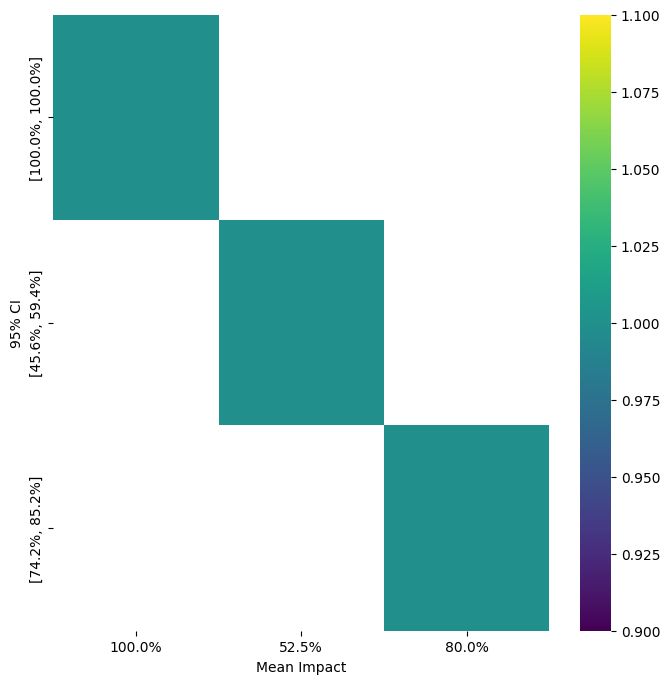

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['95% CI'].value_counts()
    for x_label, grp in _df_8.groupby('Mean Impact')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Mean Impact')
_ = plt.ylabel('95% CI')